In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Surpress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
sns.set_theme(rc={"figure.figsize": [15,5]},
              style='dark')
sns.set_context(context='notebook')
plt.style.use('dark_background')

In [3]:
df = pd.read_csv('cleaned_car_data.csv')
df.head(5)

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand
0,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


### Data Engineer

Next, we need to engineer some features, for better visualizations and analysis. We will group our data by 'brand', calculate the average price for each brand, and split these prices into 3 bins: 'Budget', 'Mid-Range', and 'Luxury' cars, naming the newly created column - the 'brand_category'.

In [4]:
data_comp_avg_price = df[['brand','price']].groupby('brand', as_index = False).mean().rename(columns={'price':'brand_avg_price'})
data_comp_avg_price.sample(5)

,brand,brand_avg_price
16,renault,9595.000000
19,toyota,9885.812500
11,mitsubishi,9239.769231
1,audi,17859.166714
2,bmw,26118.750000


In [5]:
df = df.merge(data_comp_avg_price, on = 'brand')
df.sample(5)

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand,brand_avg_price
11,gas,std,four,sedan,rwd,front,101.2,176.8,64.8,54.3,...,3.50,2.80,8.8,101,5800,23,29,16925.0,bmw,26118.750000
42,gas,std,two,sedan,fwd,front,96.5,169.1,66.0,51.0,...,3.15,3.58,9.1,100,5500,25,31,10345.0,honda,8184.692308
185,gas,std,four,sedan,fwd,front,97.3,171.7,65.5,55.7,...,3.19,3.40,9.0,85,5250,27,34,8195.0,volkswagen,10077.500000
120,gas,std,four,hatchback,fwd,front,93.7,157.3,63.8,50.6,...,2.97,3.23,9.4,68,5500,31,38,6229.0,plymouth,7963.428571
159,diesel,std,four,hatchback,fwd,front,95.7,166.3,64.4,52.8,...,3.27,3.35,22.5,56,4500,38,47,7788.0,toyota,9885.812500


We will now check the statistics of our average car price per car brand.

In [6]:
df.brand_avg_price.describe()

count      205.000000
mean     13276.710571
std       7154.179185
min       6007.000000
25%       9239.769231
50%      10077.500000
75%      15489.090909
max      34600.000000
Name: brand_avg_price, dtype: float64

In [7]:
df['brand_category'] = df['brand_avg_price'].apply(lambda x : "Budget" if x < 10000 
                                                     else ("Mid_Range" if 10000 <= x < 20000
                                                           else "Luxury"))

df.sample(5)

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,...,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand,brand_avg_price,brand_category
125,gas,std,two,hatchback,rwd,front,94.5,168.9,68.3,50.2,...,3.11,9.5,143,5500,19,27,22018.0,porsche,31400.500000,Luxury
190,gas,std,two,hatchback,fwd,front,94.5,165.7,64.0,51.4,...,3.40,8.5,90,5500,24,29,9980.0,volkswagen,10077.500000,Mid_Range
13,gas,std,four,sedan,rwd,front,101.2,176.8,64.8,54.3,...,3.19,9.0,121,4250,21,28,21105.0,bmw,26118.750000,Luxury
98,gas,std,two,hardtop,fwd,front,95.1,162.4,63.8,53.3,...,3.29,9.4,69,5200,31,37,8249.0,nissan,10415.666667,Mid_Range
3,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,...,3.40,10.0,102,5500,24,30,13950.0,audi,17859.166714,Mid_Range


### Exploratory Data Analysis

In [8]:
categorical = df.select_dtypes(include='object').columns.tolist()
categorical

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'brand',
 'brand_category']

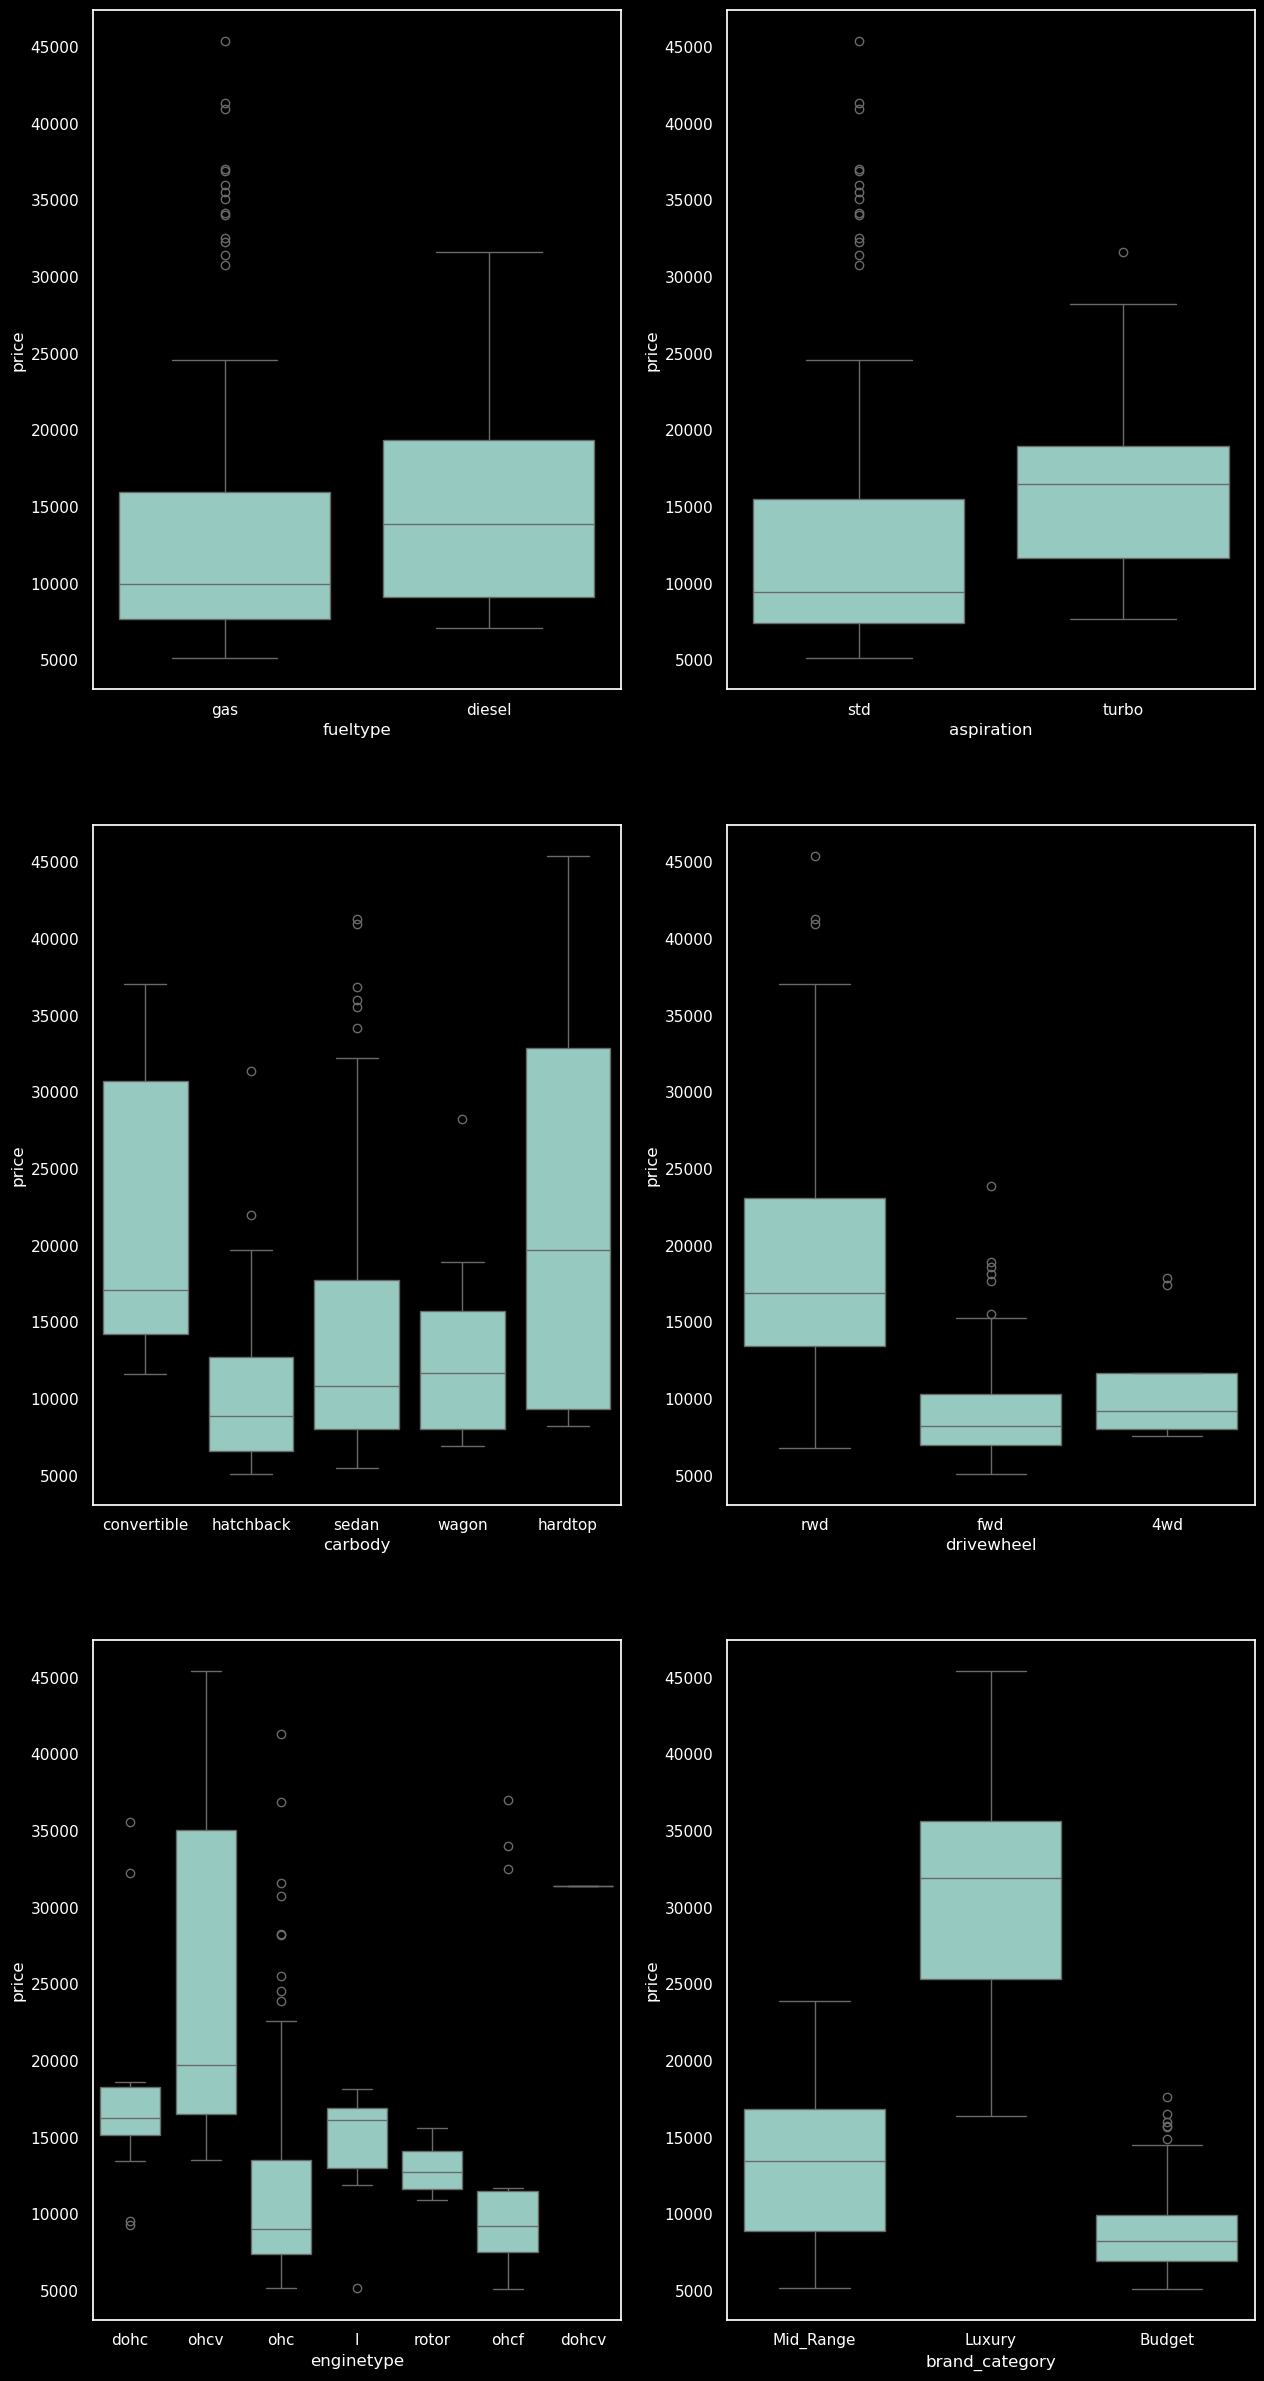

In [9]:
fig, axes = plt.subplots(3,2,figsize=(15,30))
axes = axes.flatten()

# Grafico 1 
sns.boxplot(ax=axes[0], x='fueltype', y='price', data=df)
# Grafico 2
sns.boxplot(ax=axes[1], x='aspiration', y='price', data=df)
# Grafico 3
sns.boxplot(ax=axes[2], x='carbody', y='price', data=df)
# grafico 4
sns.boxplot(ax=axes[3], x='drivewheel', y='price', data=df)
# grafico 5
sns.boxplot(ax=axes[4], x='enginetype', y='price', data=df)
# grafico 6
sns.boxplot(ax=axes[5], x='brand_category', y='price', data=df)

plt.show()

Next, let's view the list of top features that have high correlation coefficient. The `corr()` function calculates the Pearson'r correlation coefficients with respect to the `price`.

In [10]:
corr_matrix = df.corr(numeric_only=True)

corr_matrix['price'].sort_values(ascending=False)

price               1.000000
brand_avg_price     0.895520
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

These are strongly correlated numerical features with Car Price.

We can also use the heatmap() or pairplot() to further explore the relationship between all features and the target variables.

In [11]:
# # Enter your code and run the cell
# sns.pairplot(data)
# plt.show()

### Testing Assumptions for Linear Regression

### Linearity Assumption

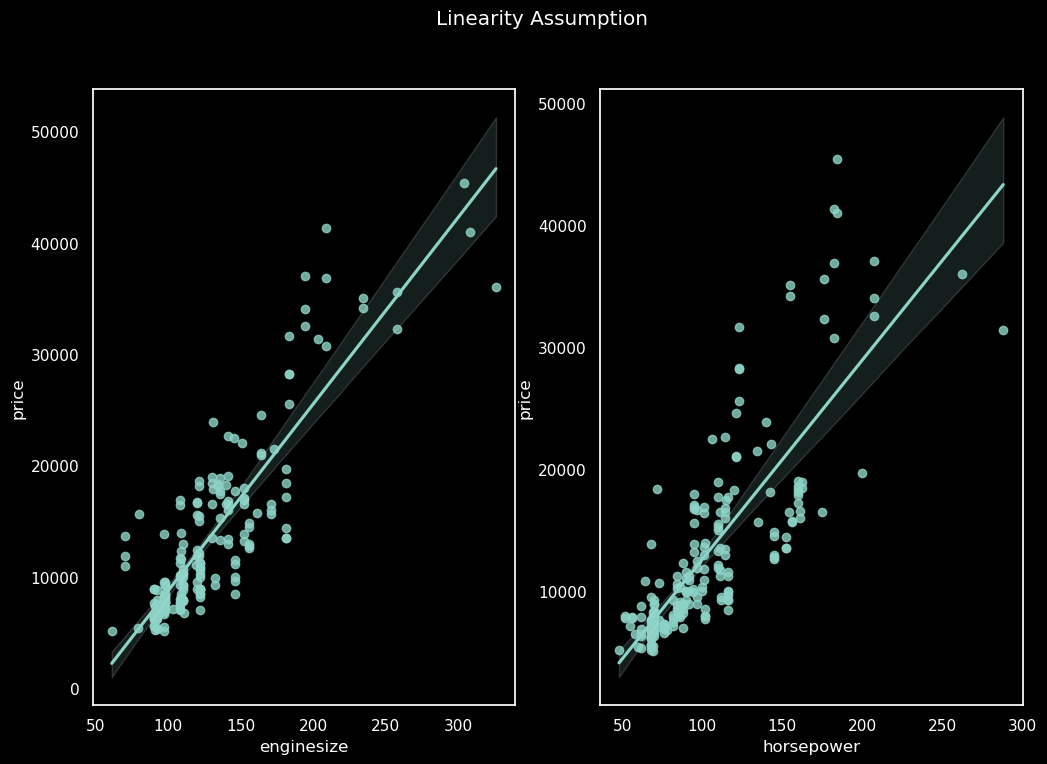

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,8))
axes = axes.flatten()

#sns.scatterplot(x=df.enginesize, y = df.price, ax=axes[0])
sns.regplot(x=df.enginesize, y=df.price, ax=axes[0])

sns.regplot(x=df.horsepower, y=df.price, ax=axes[1])


fig.suptitle('Linearity Assumption')
plt.show()

### Homoscedasticity

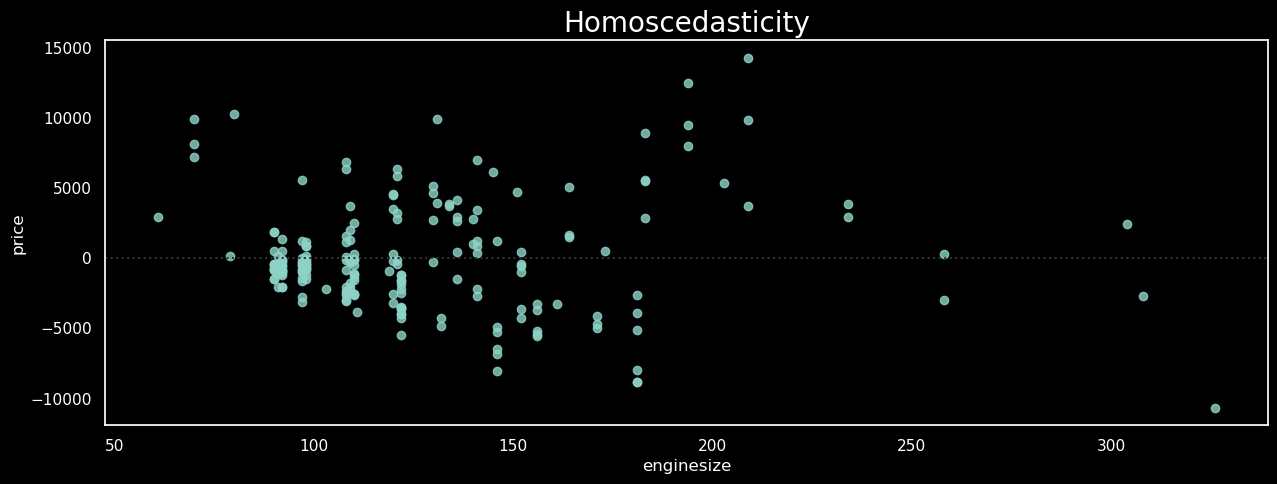

In [13]:
sns.residplot(data=df, x='enginesize', y='price')

plt.title('Homoscedasticity', fontsize=20)
plt.show()

From the above plot, we can tell the error variance across the true line is dispersed somewhat not uniformly, but in a funnel like shape. So, the assumption of the homoscedasticity is more likely not met.

### Normality

In [14]:
# Log transformation, square root transformation, box cos transformation
import matplotlib.gridspec as gridspec
from scipy import stats


def plotting_3_chart(data,feature):
    fig = plt.figure(constrained_layout=True, figsize=(12,8))

    # Creating a grid of 3 cols and 3 rows
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid
    ax1 = fig.add_subplot(grid[0,:2])

    # set the title
    ax1.set_title('Histogram')
    # plot the histogram
    sns.histplot(data.loc[:,feature], stat='density', ax=ax1)

    # Customizing the QQ_plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(data.loc[:,feature], plot=ax2)

    # Customizing the Box Plot
    ax3 = fig.add_subplot(grid[:,2])
    ax3.set_title('Box Plot')
    sns.boxplot(y=data.loc[:,feature], orient='v', ax=ax3)
    plt.show()

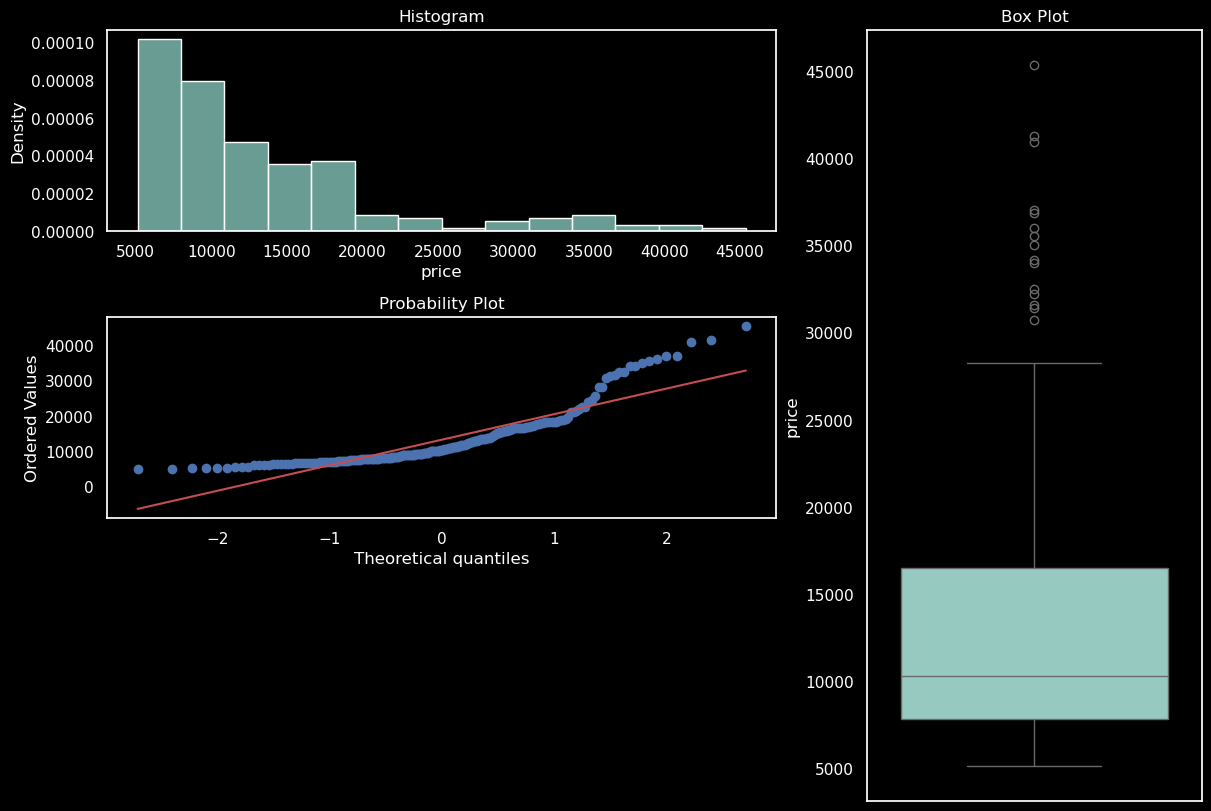

In [15]:
plotting_3_chart(df, 'price')

These three charts above can tell us a lot about our target variable:

- Our target variable, 'price' is not normally distributed
- Our target variable is right-skewed
- There are some outliers in the variable

The right-skewed plot means that most prices in the dataset are on the lower end (below 15,000). The 'max' value is very far from the '75%' quantile statistic. All these plots show that the assumption for accurate linear regression modeling is not met.

Next, we will perform the log transformation to correct our target variable and to make it more normally distributed.

But first, we will save our data that we have changed so far, in the 'previous_data' frame.

In [16]:
previous_data = df.copy()

### Log Transformation

We can also check statistically if the target is normally distributed, using normaltest() function. If the p-value is large (>0.05), the target variable is normally distributed.

In [17]:
normaltest(df.price.values)

NormaltestResult(statistic=77.37514013383584, pvalue=1.578344501676757e-17)

As we can see, the p-value is very small, so it is not normally distributed.

Now, we can try to transform our data, so it looks more normally distributed. We can use the np.log() or np.log1pfunctions from the numpy library to perform the log transformation. The np.log1p works better with smaller numbers and thus provides more accurate results. This documentation contains more information about the numpy log transform.

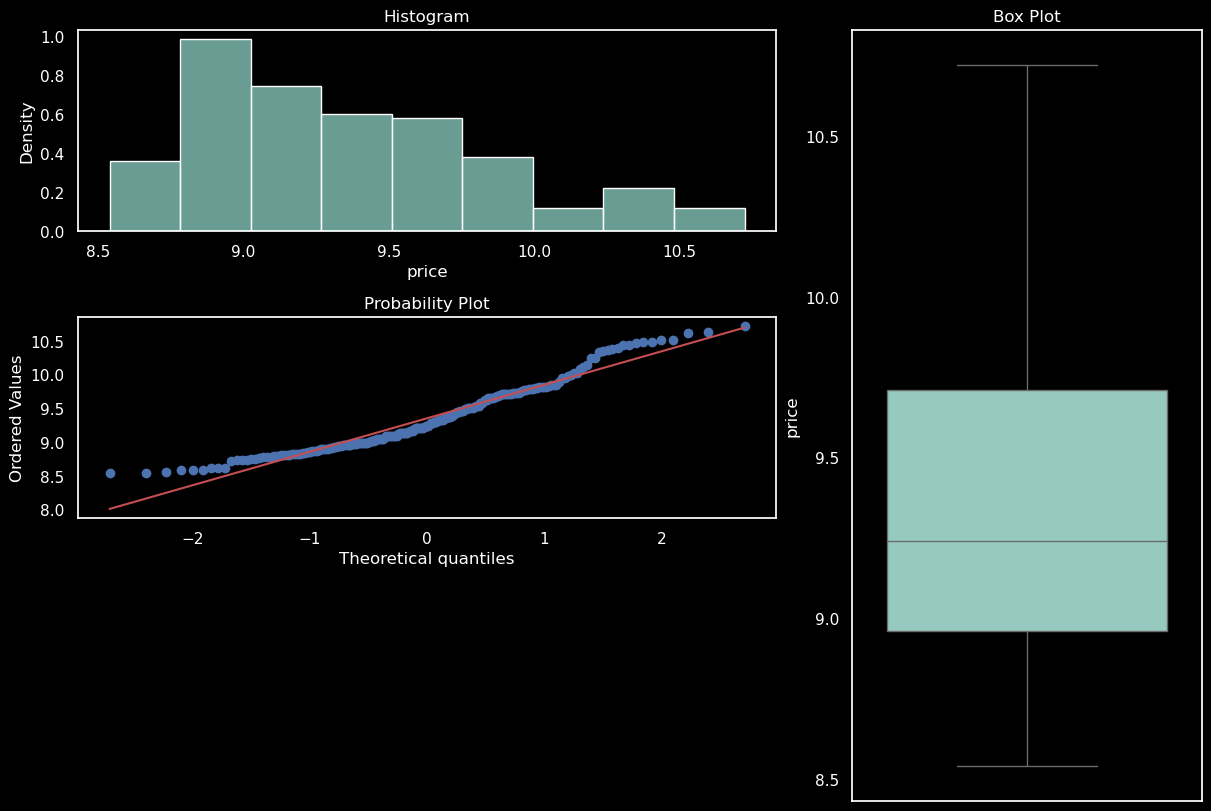

In [18]:
df['price'] = np.log(df['price'])

plotting_3_chart(df, 'price')

Let's check our p-value, after the transformation.



In [19]:
normaltest(df.price.values)

NormaltestResult(statistic=14.10341345775947, pvalue=0.0008659297880185564)

As we can see, the log method transformed the car 'price' distribution into a more symmetrical bell curve. It is still not perfect, but it is much closer to being normally distributed.

There are other ways to correct the skewed data. For example, Square Root Transform (np.sqrt) and the Box-Cox Transform (stats.boxcox from the scipy stats library). To learn more about these two methods, please check out this article.

### Multicollinearity

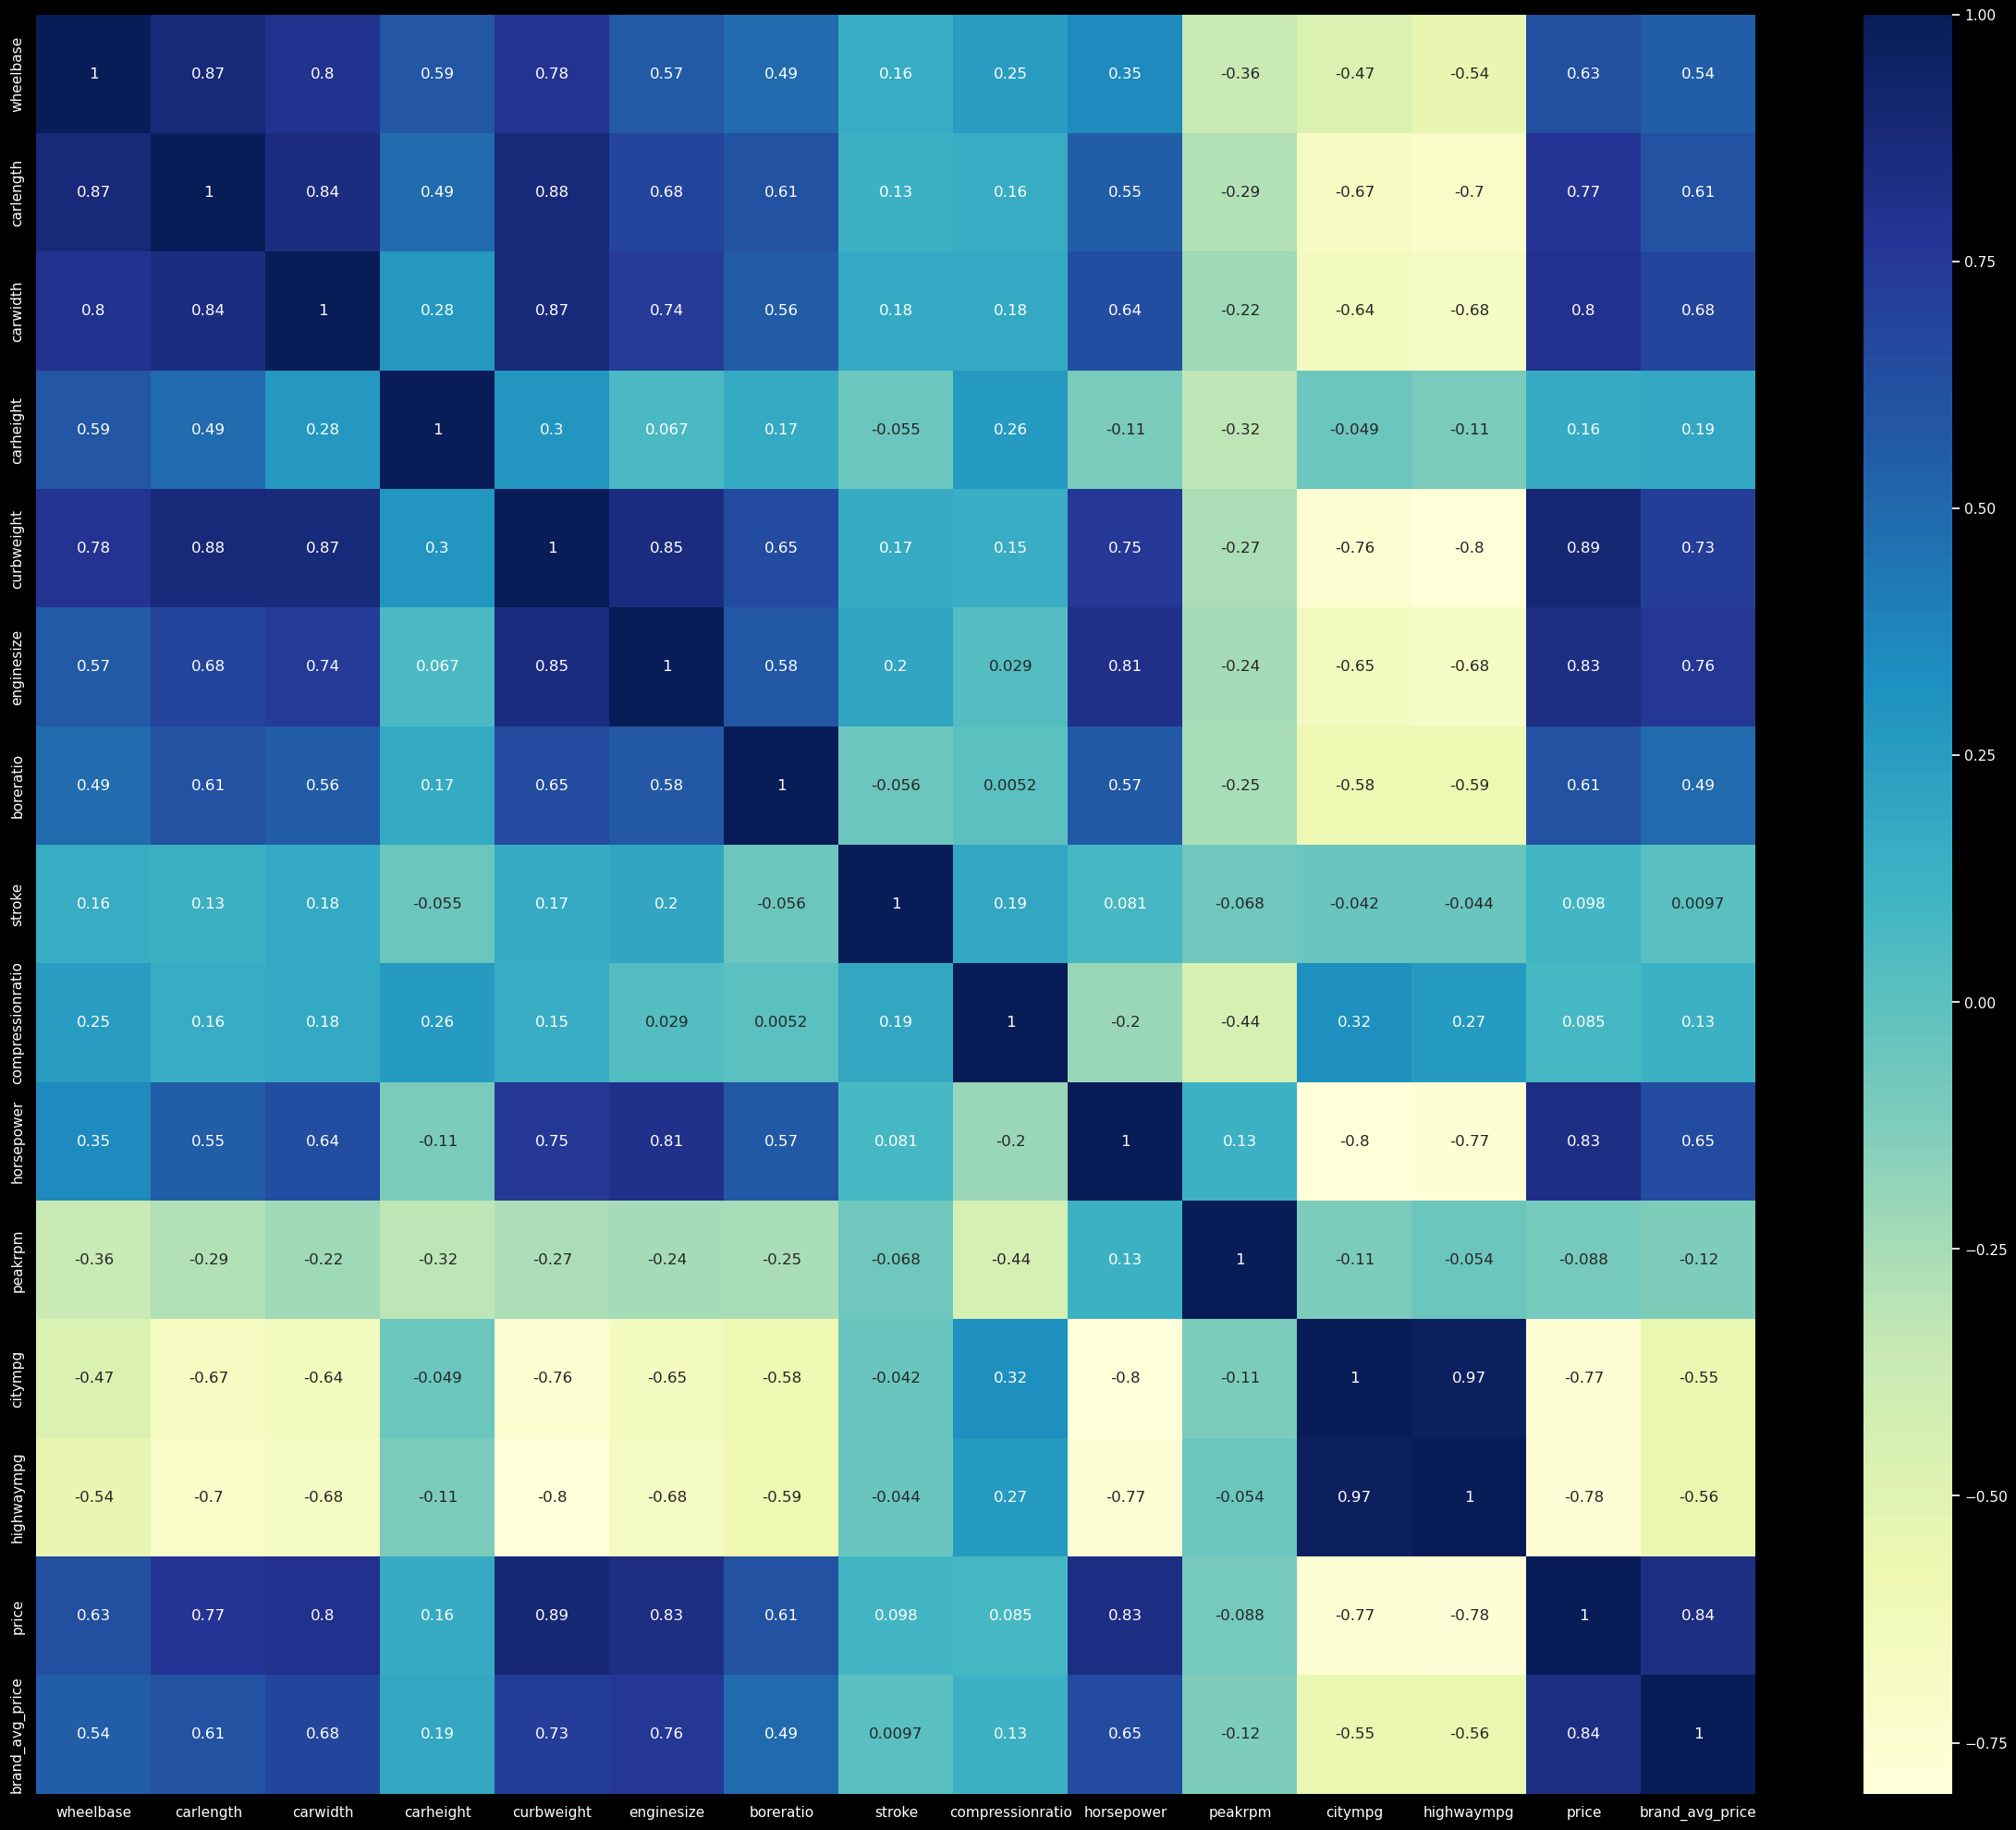

In [20]:
num = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize = (30, 25))
sns.heatmap(num.corr(), annot=True, cmap='YlGnBu')
plt.show()

As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and let the models (e.x. Regularization models such as Lasso, Ridge in the next lab) do the clean up later on.



### Linear Regression Model 

List of significant variables after Exploratory Data Analysis :

Numerical:

- Curbweight
- Car Length
- Car width
- Engine Size
- Boreratio
- Horse Power
- Wheel base
- City mpg (miles per gallon)
- Highway mpg (miles per gallon)

Categorical:

- Engine Type
- Fuel type
- Car Body
- Aspiration
- Cylinder Number
- Drivewheel
- Brand Category

We are going to put all the selected features into a data frame.

In [21]:
columns=['price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase', 'brand_category',
                  'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 'carlength','carwidth','citympg','highwaympg']



selected = df[columns]
selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           205 non-null    float64
 1   fueltype        205 non-null    object 
 2   aspiration      205 non-null    object 
 3   carbody         205 non-null    object 
 4   drivewheel      205 non-null    object 
 5   wheelbase       205 non-null    float64
 6   brand_category  205 non-null    object 
 7   curbweight      205 non-null    int64  
 8   enginetype      205 non-null    object 
 9   cylindernumber  205 non-null    object 
 10  enginesize      205 non-null    int64  
 11  boreratio       205 non-null    float64
 12  horsepower      205 non-null    int64  
 13  carlength       205 non-null    float64
 14  carwidth        205 non-null    float64
 15  citympg         205 non-null    int64  
 16  highwaympg      205 non-null    int64  
dtypes: float64(5), int64(5), object(7)


We can find the categorical and numeric columns by iterating through the dtypes attribute.

In [22]:
categorical_columns=[key for key, value in selected.dtypes.items()  if value=='O']
categorical_columns

['fueltype',
 'aspiration',
 'carbody',
 'drivewheel',
 'brand_category',
 'enginetype',
 'cylindernumber']

In [23]:
numeric_columns=list(set(columns)-set(categorical_columns))
numeric_columns

['carlength',
 'price',
 'curbweight',
 'carwidth',
 'wheelbase',
 'citympg',
 'boreratio',
 'enginesize',
 'highwaympg',
 'horsepower']

We can split the data into features X and target y

In [24]:
# Independent variables and dependable variable
X = selected.drop("price", axis=1)
X.head()

,fueltype,aspiration,carbody,drivewheel,wheelbase,brand_category,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg
0,gas,std,convertible,rwd,88.6,Mid_Range,2548,dohc,four,130,3.47,111,168.8,64.1,21,27
1,gas,std,convertible,rwd,88.6,Mid_Range,2548,dohc,four,130,3.47,111,168.8,64.1,21,27
2,gas,std,hatchback,rwd,94.5,Mid_Range,2823,ohcv,six,152,2.68,154,171.2,65.5,19,26
3,gas,std,sedan,fwd,99.8,Mid_Range,2337,ohc,four,109,3.19,102,176.6,66.2,24,30
4,gas,std,sedan,4wd,99.4,Mid_Range,2824,ohc,five,136,3.19,115,176.6,66.4,18,22


In [25]:
y = selected["price"].copy()
y.head()

0    9.510075
1    9.711116
2    9.711116
3    9.543235
4    9.767095
Name: price, dtype: float64

Before we used one-hot encoding to deal with the categorical data, let's examine the distribution of the categorical variables:



In [26]:
for column in  categorical_columns:
    print("column name:", column)
    print("value_count:")
    print( X[column].value_counts())
    print('\n')

column name: fueltype
value_count:
fueltype
gas       185
diesel     20
Name: count, dtype: int64


column name: aspiration
value_count:
aspiration
std      168
turbo     37
Name: count, dtype: int64


column name: carbody
value_count:
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64


column name: drivewheel
value_count:
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64


column name: brand_category
value_count:
brand_category
Budget       95
Mid_Range    86
Luxury       24
Name: count, dtype: int64


column name: enginetype
value_count:
enginetype
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: count, dtype: int64


column name: cylindernumber
value_count:
cylindernumber
four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: count, dtype: int64




- Observamos que muchas categoricas tiene pocas o muy pocas ocurrencias, por ejemplo three, twelve que solo ocurre una ves en la columna cylindernumber.
- Si usamos one-hot encoder usando training data, los ejemplares de la columna cylindernumber no incluirá three o twelve obtengamos un error.
- Por lo tanto, debemos usar split antes de transformar con one-hot.
- Es importante analizar la distribuciones antes de aplicar one-hot, algunas veces se tendrá que hacer antes del split, y otras después del split.

### OneHotEncoder

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [28]:
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), categorical_columns) ],
                            remainder="passthrough")
X=one_hot.fit_transform(X)
type(X)

numpy.ndarray

We see the output is a NumPy array, so let's get the feature names from the `one_hot` object using `get_feature_names_out()` method. The output will be the feature name with the prefix of the name of the transformer. For one-hot encoding, the prefix will also include the name of the column that generated that feature.

In [29]:
names=one_hot.get_feature_names_out()
names

array(['one_hot__fueltype_diesel', 'one_hot__fueltype_gas',
       'one_hot__aspiration_std', 'one_hot__aspiration_turbo',
       'one_hot__carbody_convertible', 'one_hot__carbody_hardtop',
       'one_hot__carbody_hatchback', 'one_hot__carbody_sedan',
       'one_hot__carbody_wagon', 'one_hot__drivewheel_4wd',
       'one_hot__drivewheel_fwd', 'one_hot__drivewheel_rwd',
       'one_hot__brand_category_Budget', 'one_hot__brand_category_Luxury',
       'one_hot__brand_category_Mid_Range', 'one_hot__enginetype_dohc',
       'one_hot__enginetype_dohcv', 'one_hot__enginetype_l',
       'one_hot__enginetype_ohc', 'one_hot__enginetype_ohcf',
       'one_hot__enginetype_ohcv', 'one_hot__enginetype_rotor',
       'one_hot__cylindernumber_eight', 'one_hot__cylindernumber_five',
       'one_hot__cylindernumber_four', 'one_hot__cylindernumber_six',
       'one_hot__cylindernumber_three', 'one_hot__cylindernumber_twelve',
       'one_hot__cylindernumber_two', 'remainder__wheelbase',
       'remain

Let's strip out the prefix of the string.

In [30]:

colunm_names=[name[name.find("_")+1:] for name in  
              [name[name.find("__")+2:] for name in names]]
colunm_names

['diesel',
 'gas',
 'std',
 'turbo',
 'convertible',
 'hardtop',
 'hatchback',
 'sedan',
 'wagon',
 '4wd',
 'fwd',
 'rwd',
 'category_Budget',
 'category_Luxury',
 'category_Mid_Range',
 'dohc',
 'dohcv',
 'l',
 'ohc',
 'ohcf',
 'ohcv',
 'rotor',
 'eight',
 'five',
 'four',
 'six',
 'three',
 'twelve',
 'two',
 'wheelbase',
 'curbweight',
 'enginesize',
 'boreratio',
 'horsepower',
 'carlength',
 'carwidth',
 'citympg',
 'highwaympg']

In [31]:

data=pd.DataFrame(data=X,columns=colunm_names)

#df.to_csv('cleaned_car_data.csv', index=False)

### Train Test split

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.30, random_state=0)


### Standarize the data


In [34]:
from sklearn.preprocessing import StandardScaler


In [35]:
ss = StandardScaler()

# fit our training data 
X_train=ss.fit_transform(X_train)


### Linear Regression

In [36]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

### Making Prediction

In [37]:
X_test=ss.transform(X_test)
car_price_predictions = lm.predict(X_test)
car_price_predictions

array([ 8.86257510e+00,  9.78933291e+00,  9.36306338e+00, -8.52321063e+12,
        9.23952822e+00,  9.33132510e+00,  8.67678408e+00,  8.78909640e+00,
        9.70241885e+00,  8.82546572e+00,  9.87722353e+00, -1.55612716e+12,
        9.43288760e+00,  9.58132510e+00,  8.71120791e+00,  9.26442294e+00,
        9.08547549e+00,  9.62331728e+00,  8.98903994e+00,  8.77199893e+00,
        9.20022158e+00,  9.55886416e+00,  9.09865908e+00,  9.31305270e+00,
        9.80886416e+00,  8.83108096e+00,  8.87038760e+00,  9.58803896e+00,
        8.86843447e+00,  8.85476260e+00,  9.12624697e+00,  9.24709658e+00,
        1.00008808e+01,  9.09402041e+00,  8.86941103e+00,  1.03987079e+01,
        9.44460635e+00,  9.66848330e+00,  8.75588564e+00,  1.04172626e+01,
        8.70046572e+00,  9.44558291e+00,  1.05017353e+01,  9.38137393e+00,
        9.26113467e+00,  8.82253603e+00,  8.82351260e+00,  9.43984561e+00,
        9.20583682e+00,  9.14577822e+00,  9.86452822e+00,  8.92800478e+00,
        8.93630557e+00,  

### Model Evaluation

In [38]:
mse = mean_squared_error(y_test, car_price_predictions)
mse

1.2107524388008745e+24

In [39]:
lm.score(X_test, y_test)

-4.705040652959211e+24

In [40]:
lm.score(X_test,y_test)

-4.705040652959211e+24

In [41]:
from sklearn.metrics import r2_score

In [42]:
r2_score(y_test,car_price_predictions)

-4.705040652959211e+24

### Pipeline object

In [43]:
steps = [('scaler', StandardScaler()),
         ('lm', LinearRegression())]

We input the list as an argument to the pipeline constructor.



In [44]:
pipe = Pipeline(steps=steps)

In [45]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

In [46]:
car_price_predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, car_price_predictions)
rmse = np.sqrt(mse)
r2score = r2_score(car_price_predictions, y_test)

print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"r2_score {r2score}")

mse: 3.0343251797164175e+24
rmse: 1741931450923.4907
r2_score -0.032648735278264285


In [47]:
X = selected[categorical_columns + numeric_columns]

one_hot = ColumnTransformer(transformers=[('one_hot', OneHotEncoder(), categorical_columns)],
                            remainder='passthrough')

In [48]:
steps = [('one_hot', one_hot),
         ('scaler', StandardScaler()),
         ('lm', LinearRegression())]

In [49]:
pipe = Pipeline(steps=steps)
pipe.fit(X,y)

Pipeline(steps=[('one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['fueltype', 'aspiration',
                                                   'carbody', 'drivewheel',
                                                   'brand_category',
                                                   'enginetype',
                                                   'cylindernumber'])])),
                ('scaler', StandardScaler()), ('lm', LinearRegression())])

In [50]:
car_price_predictions=pipe.predict(X)
r2_score(car_price_predictions, y)

1.0